# Spatial Integration


Conservation laws in their integral form require spatial integration. In experiments or simulations, this integration must be performed from a discrete number of points. This notebook discusses one approach to perform such integration.

## A Practical Example: Bulk velocity in a pipe flow

Consider the flow of an incompressible fluid of density $\rho$ in a pipe of radius $R$. The flow direction is $x$ direction. The mean velocity is assumed to be axisymmetric, 
$$
\bar{U}(x,r,\theta)=\bar{U}(x,r)
$$

The mass flow rate in the streamwise direction is (watch for the integrand in cylindrical coordinates)
$$
\dot{m}_x(x)=\int_{0}^{2\pi}\int_{0}^{R}\rho\bar{U}(x,r)\,r\,dr\,d\theta=2\pi\int_{0}^{R}\bar{U}(x,r)\,r\,dr
$$

The mean velocity is measured at $N$ **discrete** points located at radii $r_i$, $i=0,...,N-1$. The mass flow rate becomes
$$
\dot{m}_x(x)\approx2\pi\rho\sum_{i=1}^{N-1}\underbrace{\frac{\bar{U}_i(x)+\bar{U}_{i-1}(x)}{2}}_{\bar{U}_{i+\frac{1}{2}}}\underbrace{\frac{r_i+r_{i-1}}{2}}_{r_{i+\frac{1}{2}}}\underbrace{(r_i - r_{i-1})}_{\Delta r_{i+\frac{1}{2}}}
$$

The bulk velocity is defined as,

$$
U_b=\frac{\dot{m}}{\int_0^{2\pi}\int_0^R\rho\,r\,dr\,d\theta}=\frac{\dot{m}}{\rho\pi R^2}
$$

The first step is to read the manometer data connected to a Pitot tube at various radial locations. Each excel file contains a recording of the pressure difference $\Delta P$ between the dynamic and static ports with a sampling frequency of 1 Hz. Recordings are long enough to have reasonable confidence in the convergence of the mean and standard deviation of $\Delta P$. The velocity is derived from Bernoulli equation:
$$
U=\sqrt{\frac{2\Delta P}{\rho}}
$$
The uncertainty of $\Delta P$ is the sum of its standard deviation and the measurement error of the manometer, 0.001 kPa. The uncertainty of $U$ is derived using uncertainty propagation, assuming no uncertainty on the fluid density $\rho$.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filenumber = np.array([2,3,4,5,6,10,15,20,25,30,35,40])
r = filenumber - 1.5
DPmean = np.zeros_like(r,dtype=np.float)
DPstd = np.zeros_like(r,dtype=np.float)
i = 0
for y in filenumber:
    filename = str(y)+".xlsx"
#     print(filename)
    df = pd.read_excel("data/Orifice data/"+filename,)
    DPmean[i] = np.mean(df['DATA'][:])*1000.
    DPstd[i] = np.std(df['DATA'][:])*1e3+0.0001*1e3
    i += 1

The second step computes and plots the mean velocity and its uncertainty.

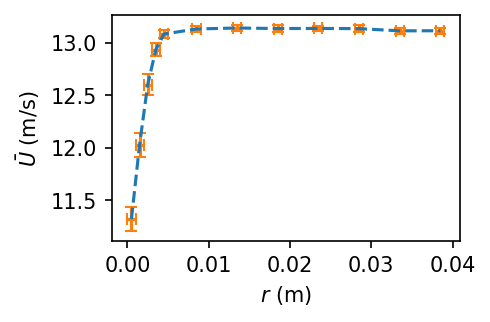

In [2]:
rho = 1.2
Umean = np.sqrt(2*DPmean/rho)
sigma_U = DPstd*(1/(2*rho))/np.sqrt(DPmean)
sigma_r = 0.5*np.ones_like(r)*1e-3
# plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(3,2),dpi=150)
plt.errorbar(r*1e-3,Umean,xerr=sigma_r,yerr=sigma_U,capsize=3,ecolor="C1",fmt="--")
plt.xlabel(r"$r$ (m)")
plt.ylabel(r"$\bar{U}$ (m/s)")
plt.show()

The error for the mass flow rate is derived from error progragation. An error of 0.5mm is assumed on the radius, and the distance between two data positions.

To simplify future derivations we define
$$
\tilde{U}_i=\frac{U_{i+1}+U_{i}}{2} \\
\tilde{r}_i=\frac{r_{i+1}+r_{i}}{2} \\
\tilde{\Delta r}_i=\frac{\Delta r_{i+1}+\Delta r_{i}}{2} \\
$$
yielding
$$
\dot{m}=2\pi \rho\sum_{i=1}^{N-1}\Delta\dot{m}_i=2\pi \rho\sum_{i=1}^{N-1}\tilde{U}_i\tilde{r}_{i}\tilde{\Delta r}_i
$$
It is important to note that the number of variable for each $i+\frac{1}{2}$ location is $3$, and the number of variables involved in the mass flow rate is $3(N-1)$

Therefore the uncertainty for the mass flow rate is
$$
\sigma_\dot{m}^2=\sum_{i=1}^{N-1}\left[\left(\left.\sigma_{\tilde{U}}\right\vert_{r=\tilde{r}_i}\left.\frac{\partial \dot{m}}{\partial \tilde{U}_{i}}\right\vert_{r=\tilde{r}_i}\right)^2+\left(\left.\sigma_{\tilde{r}}\right\vert_{r=\tilde{r}_i}\left.\frac{\partial \dot{m}}{\partial \tilde{r}_{i}}\right\vert_{r=\tilde{r}_i}\right)^2+\left(\left.\sigma_{\tilde{\Delta r}}\right\vert_{r=\tilde{r}_i}\left.\frac{\partial \dot{m}}{\partial \tilde{\Delta r}_{i}}\right\vert_{r=\tilde{r}_i}\right)^2\right]
$$

$$
\sigma_\dot{m}^2=(2\pi\rho)^2\sum_{i=1}^{N-1}\left[\left(\left.\sigma_{\tilde{U}}\right\vert_{r=\tilde{r}_i}\left.\tilde{r}_{i}\tilde{\Delta r}_i\right\vert_{r=\tilde{r}_i}\right)^2+\left(\left.\sigma_{\tilde{r}}\right\vert_{r=\tilde{r}_i}\left.\tilde{U}_i\tilde{\Delta r}_i\right\vert_{r=\tilde{r}_i}\right)^2+\left(\left.\sigma_{\tilde{\Delta r}}\right\vert_{r=\tilde{r}_i}\left.\tilde{U}_i\tilde{r}_{i}\right\vert_{r=\tilde{r}_i}\right)^2\right]
$$

To showcase the distribution of uncertainty associated with the trapezoidal rule of integration, the following computes $\Delta\dot{m}_i$ and its error, before calculating the mass flowrate and the bulk velocity.

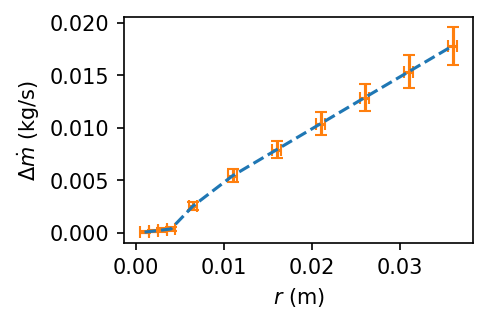

In [3]:
#Compute U_i+1/2, sigma_U_i+1/2 r_i+1/2,dr_i+1/2
U_half = (Umean[1:] + Umean[:-1])/2.
r_half = (r[1:] + r[:-1])/2.*1e-3
dr_half = (r[1:] - r[:-1])*1e-3
sigma_U_half = (sigma_U[1:] + sigma_U[:-1])/2.
sigma_dr_half = 0.5e-3*np.ones_like(sigma_U_half)
sigma_r_half = 0.5e-3*np.ones_like(sigma_U_half)

sigma_Dmdot = 2*np.pi*rho*np.sqrt((sigma_U_half*r_half*dr_half)**2 + 
                                 (sigma_r_half*U_half*dr_half)**2 + 
                                 (sigma_dr_half*U_half*r_half)**2)
Dmdot = 2*np.pi*rho*U_half*r_half*dr_half
plt.figure(figsize=(3,2),dpi=150)
plt.errorbar(r_half,Dmdot,xerr=sigma_r_half,yerr=sigma_Dmdot,capsize=3,ecolor="C1",fmt="--")
plt.xlabel(r"$r$ (m)")
plt.ylabel(r"$\Delta\dot{m}$ (kg/s)")
plt.show()

In [4]:
sigma_mdot = np.sqrt(np.sum(sigma_Dmdot**2))
mdot = np.sum(Dmdot)

In [5]:
print("The mass flowrate is %.3f +/- %.3f kg/s" %(mdot,sigma_mdot))

The mass flowrate is 0.073 +/- 0.003 kg/s


In [6]:
Ubulk = mdot/(np.pi*(40*1e-3)**2*rho)
sigma_Ubulk = sigma_mdot/(np.pi*(40*1e-3)**2*rho)
print("The bulk velocity is %.2f +/- %.2f m/s" %(Ubulk,sigma_Ubulk))

The bulk velocity is 12.15 +/- 0.52 m/s
